# 最小限のMNIST

*   Google Colaboratory環境用
*   3層バックプロパゲーション


In [1]:
import ipywidgets as widgets

modelinit_button = widgets.RadioButtons(
    options = ['new', 'load'],
    value = 'load',
    description = 'model initialize :',
    disabled = False
)

modelinit_button


RadioButtons(description='model initialize :', index=1, options=('new', 'load'), value='load')

In [2]:
# 初期化に必要なライブラリ
import os
import subprocess

# 子プロセスでシェルコマンドを実行する関数
def do_system(cmds) :
    for cmd in cmds :
        subp = subprocess.run(
            cmd,
            shell = True,
            stdout = subprocess.PIPE,
            stderr = subprocess.PIPE
            )
        print(subp.stdout.decode(), subp.stderr.decode())


In [3]:
# 環境依存の初期化
if 'COLAB_GPU' in set(os.environ.keys()) :
    # Google Colaboratory内
    if not os.path.exists('./model') :
        do_system(["ln -s '/content/drive/My Drive/Colab Data/' ./model"])

!ls ./model

 
efficientdet_d0_1	  mobilenetv2_coco_voctrainaug
efficientdet_d0_1.tar.gz  mscoco_label_map.pbtxt
MNIST_minimum		  ssd_mobilenet_v2_2
MNIST_minimum.h5	  ssd_mobilenet_v2_2.tar.gz


In [25]:
# ライブラリ読込み

import json

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds


In [5]:
# データセット読込み
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split = ['train', 'test'],
    shuffle_files = True,
    as_supervised = True,
    with_info = True,
)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


初期化ここまで

In [6]:
# データ水増し
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1
    )

def tfds_imgen(ds, imgen, batch_size = 32) :
    while True :
        for images, labels in ds.batch(batch_size).as_numpy_iterator() :
            flow_ = imgen.flow(images, labels, batch_size = batch_size)
            yield next(flow_)

batch_size = 125

ds_train_a = tfds_imgen(
    ds_train,
    datagen,
    batch_size = batch_size
    )

steps_per_epoch = len(ds_train) // batch_size
print(steps_per_epoch)

# データセットから1枚取り出して確認
#image, label = next(ds_train_a)

#print(label)

#plt.figure(figsize = (5, 5))
#plt.imshow(np.squeeze(image[0]), cmap = 'gray')


480


In [7]:
if modelinit_button.value == 'new' :
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape = (28, 28, 1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Lambda(lambda x: x / 255.0),
#        tf.keras.layers.Flatten(),
#        tf.keras.layers.Dense(8, activation = 'relu'),
        tf.keras.layers.Conv2D(8, 3, 2, activation = 'relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = 'softmax')    
    ])

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
        )
else :
    model = tf.keras.models.load_model('./model/MNIST_minimum')

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [8]:
if modelinit_button.value == 'new' :
    model.fit(
        ds_train_a,
        epochs = 10,
        steps_per_epoch = steps_per_epoch,
        validation_data = ds_test.batch(batch_size)
        )

    model.save_weights('./model/MNIST_minimum.h5')
    model.save('./model/MNIST_minimum')


4


<BarContainer object of 10 artists>

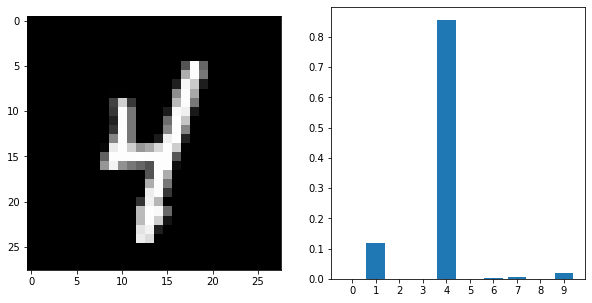

In [9]:
# データセットから1枚取り出して予測を確認
image, label = next(ds_train.skip(0).take(1).as_numpy_iterator())
result = model.predict(image.reshape((-1, 28, 28, 1)))[0]

x = np.arange(len(result))

print(label)

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap = 'gray')

plt.subplot(1, 2, 2)
plt.bar(x, result, tick_label = x)


# 入力値確認

In [10]:
from pprint import pprint
pprint(np.squeeze(image).tolist(), width=120)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 254, 101, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 253, 119, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 247, 202, 29, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 141, 253, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 208, 56, 0, 0, 0, 0, 186, 253, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 253, 119, 0, 0, 0, 28, 249, 240, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0],

In [11]:
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('conv2d').output)


In [12]:
pprint(hidden_layer_model.predict(image.reshape((-1, 28, 28, 1)))[0][:,:,0].tolist(), width=2000)


[[0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313],
 [0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313],
 [0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.9164448976516724, 1.1884207725524902, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313],
 [0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47286373376846313, 0.47863778471946716, 0.4758322834968567, 0.47286373376846313, 0.6358394622802734, 0.0, 0

# 重み出力

In [26]:
model_js = {}

for weights in model.weights :
    model_js[weights.name] = weights.numpy().tolist()

with open('./model/MNIST_minimum.json', 'w') as f:
    json.dump(model_js, f, indent = 4)